In [1]:
import utils.plot as plot
import utils.fer2013 as fer2013
from utils.hparams import HPS
import utils.loops as loops

import numpy as np
import torch
import cv2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Load Dataset with Data Augmentation Strategy

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augment_tf = A.Compose([
    A.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.0), interpolation=cv2.INTER_LINEAR),
    A.Affine(translate_percent=(-0.2, 0.2), interpolation=cv2.INTER_NEAREST, mode=cv2.BORDER_REPLICATE),
    A.HorizontalFlip(),
    A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE),
    ToTensorV2(),
])

train_loader, valid_loader, test_loader = fer2013.get_dataloaders(augment_tf, HPS['batch_size'])

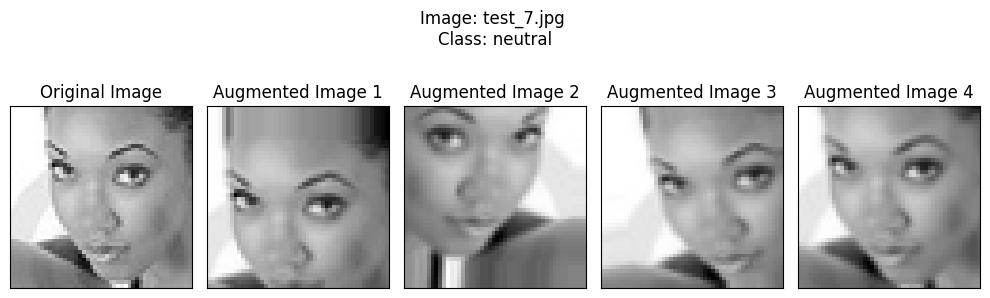

In [3]:
plot.plot_augmentation(test_loader, 'test', augment_tf)

### 2. Class Weights

#### 2a. Plot Dataset 

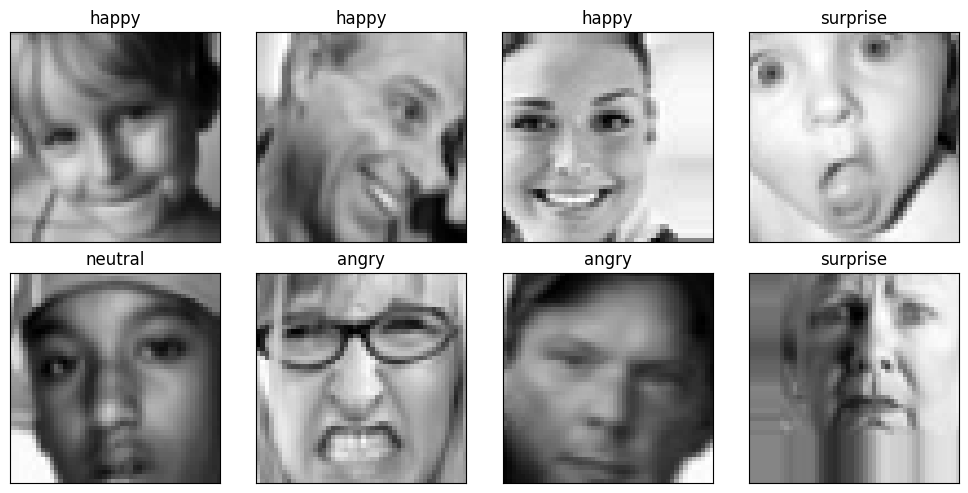

In [4]:
plot.plot_fer_dataset(train_loader)

#### 2b. Create Class Weights for Imbalanced Data

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')


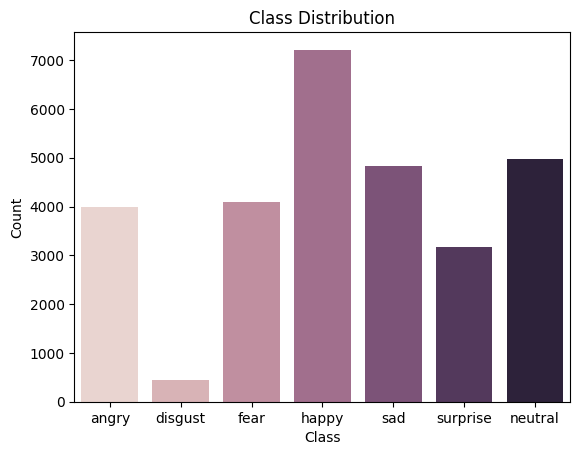

In [5]:
train_class_weights = fer2013.get_class_weights(DEVICE)
print(train_class_weights)

### 3. Train and Evaluate Functions

In [6]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        '''
        Arguments:
            patience (int): number of times to allow for no improvement before stopping the execution
            min_delta (float): minimum change counted as an improvement
        '''
        self.patience = patience 
        self.min_delta = min_delta
        self.counter = 0 # internal counter
        self.min_validation_loss = np.inf

    # Return True when validation loss is not decreased by `min_delta` `patience` times 
    def early_stop(self, validation_loss):
        if ((validation_loss + self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif ((validation_loss + self.min_delta) > self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def get_patience(self):
        return self.patience

def run_model(model, optimizer, train_loader, valid_loader, criterion, scheduler, scaler, num_epochs, model_name):
    print(f'Training {model_name} on {DEVICE}')
    model.to(DEVICE)
    best_accuracy_train, best_accuracy_val = 0.0, 0.0
    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    best_y_true = []
    best_y_pred = []
    early_stopper = EarlyStopper()
    for epoch in range(num_epochs):
        print('.' * 64)
        print(f"--- Epoch {epoch + 1}/{num_epochs} ---")
        
        tr_accuracy, tr_loss = loops.train_model(model, train_loader, optimizer, criterion, scaler, epoch, num_epochs)
        print(f'train_loss: {tr_loss:.4f} - train_accuracy: {tr_accuracy:.4f}')
        
        # Update best model on train dataset
        if tr_accuracy > best_accuracy_train:
            best_accuracy_train = tr_accuracy
            torch.save(model.state_dict(), f'./models/outputs/{model_name}_best_train.pth')
        
        val_accuracy, val_loss, y_true, y_pred = loops.evaluate_model(model, valid_loader, criterion)
        
        # Update learning rate
        prev_lr = scheduler.get_last_lr()[0]
        scheduler.step(val_loss)
        curr_lr = scheduler.get_last_lr()[0]
        
        if prev_lr > curr_lr:  
            print(f'Updating lr {prev_lr}->{curr_lr}')
        
        # Update best model on validation dataset
        if val_accuracy > best_accuracy_val:
            best_y_true = y_true
            best_y_pred = y_pred
            best_accuracy_val = val_accuracy
            torch.save(model.state_dict(), f'./models/outputs/{model_name}_best_valid.pth')

        train_acc.append(tr_accuracy)
        train_loss.append(tr_loss)
        valid_acc.append(val_accuracy)
        valid_loss.append(val_loss)
        
        # Early stopping
        if early_stopper.early_stop(val_loss):
            print(f'Stopping early at Epoch {epoch + 1}, min val loss failed to decrease after {early_stopper.get_patience()} epochs')
            break

    return {
        'train_accuracy': train_acc,
        'train_loss': train_loss,
        'valid_accuracy': valid_acc,
        'valid_loss': valid_loss,
        'y_true': best_y_true,
        'y_pred': best_y_pred
    }

### 4. Train Model

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler

Run the cell of a model. Available models:
- VGGNet
- ResNet50
- EfficientNetB0

In [11]:
# VGGNet
from models import vgg
model = vgg.Vgg()
model_name = 'VGGNet'

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=HPS['lr'], momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
scaler = GradScaler()

In [25]:
# ResNet50
from models import resnet
model = resnet.ResNet50()
model_name = 'ResNet50'

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=HPS['lr'], weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
scaler = GradScaler()

In [13]:
# EfficientNetB0
from models import efn
model = efn.EfficientNetB0()
model_name = 'EfficientNetB0'

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=HPS['lr'], weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5)
scaler = GradScaler()

In [12]:
results = run_model(model, optimizer, train_loader, valid_loader, criterion, scheduler, scaler, HPS['num_epochs'], model_name)

Training VGGNet on cuda
................................................................
--- Epoch 1/300 ---


  0%|          | 0/449 [00:00<?, ?it/s]/home/vincent/anaconda3/envs/projects/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train_loss: 0.0248 - train_accuracy: 0.3692
validation_loss: 0.0250 - valid_accuracy: 0.3611
................................................................
--- Epoch 2/300 ---


train_loss: 0.0207 - train_accuracy: 0.4948
validation_loss: 0.0211 - valid_accuracy: 0.4990
................................................................
--- Epoch 3/300 ---


train_loss: 0.0190 - train_accuracy: 0.5428
validation_loss: 0.0213 - valid_accuracy: 0.5130
................................................................
--- Epoch 4/300 ---


train_loss: 0.0180 - train_accuracy: 0.5634
validation_loss: 0.0181 - valid_accuracy: 0.5678
................................................................
--- Epoch 5/300 ---


train_loss: 0.0173 - train_accuracy: 0.5828
validation_loss: 0.0184 - valid_accuracy: 0.5729
................................................................
--- Epoch 6/300 ---


train_loss: 0.0168 - train_accuracy: 0.5946
validation_loss: 0.0171 - valid_accuracy: 0.5913
................................................................
--- Epoch 7/300 ---


train_loss: 0.0164 - train_accuracy: 0.6087
validation_loss: 0.0183 - valid_accuracy: 0.5745
Updating lr 0.01->0.0075
................................................................
--- Epoch 8/300 ---


train_loss: 0.0156 - train_accuracy: 0.6258
validation_loss: 0.0170 - valid_accuracy: 0.5932
................................................................
--- Epoch 9/300 ---


train_loss: 0.0153 - train_accuracy: 0.6314
validation_loss: 0.0161 - valid_accuracy: 0.6174
................................................................
--- Epoch 10/300 ---


train_loss: 0.0150 - train_accuracy: 0.6414
validation_loss: 0.0161 - valid_accuracy: 0.6199
................................................................
--- Epoch 11/300 ---


train_loss: 0.0148 - train_accuracy: 0.6453
validation_loss: 0.0156 - valid_accuracy: 0.6411
................................................................
--- Epoch 12/300 ---


train_loss: 0.0146 - train_accuracy: 0.6535
validation_loss: 0.0158 - valid_accuracy: 0.6397
................................................................
--- Epoch 13/300 ---


train_loss: 0.0143 - train_accuracy: 0.6594
validation_loss: 0.0155 - valid_accuracy: 0.6275
Updating lr 0.0075->0.005625
................................................................
--- Epoch 14/300 ---


train_loss: 0.0138 - train_accuracy: 0.6658
validation_loss: 0.0167 - valid_accuracy: 0.6199
................................................................
--- Epoch 15/300 ---


train_loss: 0.0135 - train_accuracy: 0.6773
validation_loss: 0.0153 - valid_accuracy: 0.6411
................................................................
--- Epoch 16/300 ---


train_loss: 0.0133 - train_accuracy: 0.6785
validation_loss: 0.0157 - valid_accuracy: 0.6400
................................................................
--- Epoch 17/300 ---


train_loss: 0.0132 - train_accuracy: 0.6826
validation_loss: 0.0156 - valid_accuracy: 0.6417
................................................................
--- Epoch 18/300 ---


train_loss: 0.0129 - train_accuracy: 0.6924
validation_loss: 0.0153 - valid_accuracy: 0.6481
................................................................
--- Epoch 19/300 ---


train_loss: 0.0129 - train_accuracy: 0.6919
validation_loss: 0.0162 - valid_accuracy: 0.6356
Updating lr 0.005625->0.00421875
................................................................
--- Epoch 20/300 ---


train_loss: 0.0123 - train_accuracy: 0.7056
validation_loss: 0.0147 - valid_accuracy: 0.6573
................................................................
--- Epoch 21/300 ---


train_loss: 0.0121 - train_accuracy: 0.7108
validation_loss: 0.0153 - valid_accuracy: 0.6512
................................................................
--- Epoch 22/300 ---


train_loss: 0.0119 - train_accuracy: 0.7166
validation_loss: 0.0157 - valid_accuracy: 0.6595
................................................................
--- Epoch 23/300 ---


train_loss: 0.0118 - train_accuracy: 0.7167
validation_loss: 0.0151 - valid_accuracy: 0.6539
................................................................
--- Epoch 24/300 ---


train_loss: 0.0116 - train_accuracy: 0.7230
validation_loss: 0.0154 - valid_accuracy: 0.6615
................................................................
--- Epoch 25/300 ---


train_loss: 0.0115 - train_accuracy: 0.7269
validation_loss: 0.0155 - valid_accuracy: 0.6565
Updating lr 0.00421875->0.0031640625
................................................................
--- Epoch 26/300 ---


train_loss: 0.0109 - train_accuracy: 0.7398
validation_loss: 0.0152 - valid_accuracy: 0.6676
................................................................
--- Epoch 27/300 ---


train_loss: 0.0108 - train_accuracy: 0.7410
validation_loss: 0.0161 - valid_accuracy: 0.6495
................................................................
--- Epoch 28/300 ---


train_loss: 0.0107 - train_accuracy: 0.7454
validation_loss: 0.0161 - valid_accuracy: 0.6573
................................................................
--- Epoch 29/300 ---


train_loss: 0.0106 - train_accuracy: 0.7448
validation_loss: 0.0148 - valid_accuracy: 0.6723
................................................................
--- Epoch 30/300 ---


train_loss: 0.0104 - train_accuracy: 0.7529
validation_loss: 0.0150 - valid_accuracy: 0.6687
Stopping early at Epoch 30, min val loss failed to decrease after 10 epochs


### 5. Model Evaluation

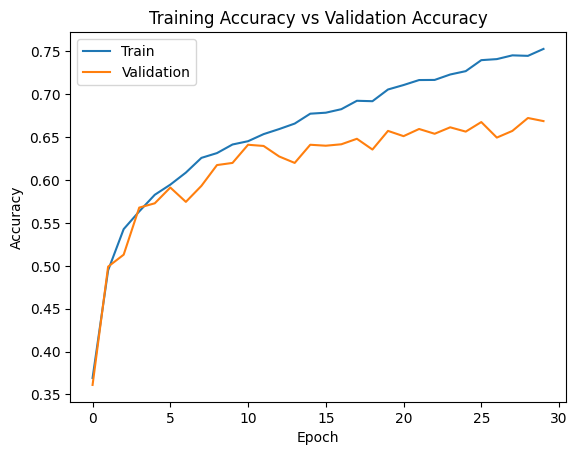

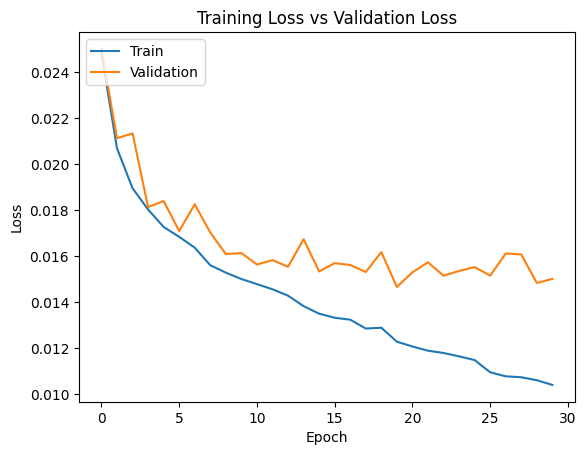

In [13]:
plot.plot_training_history(results)

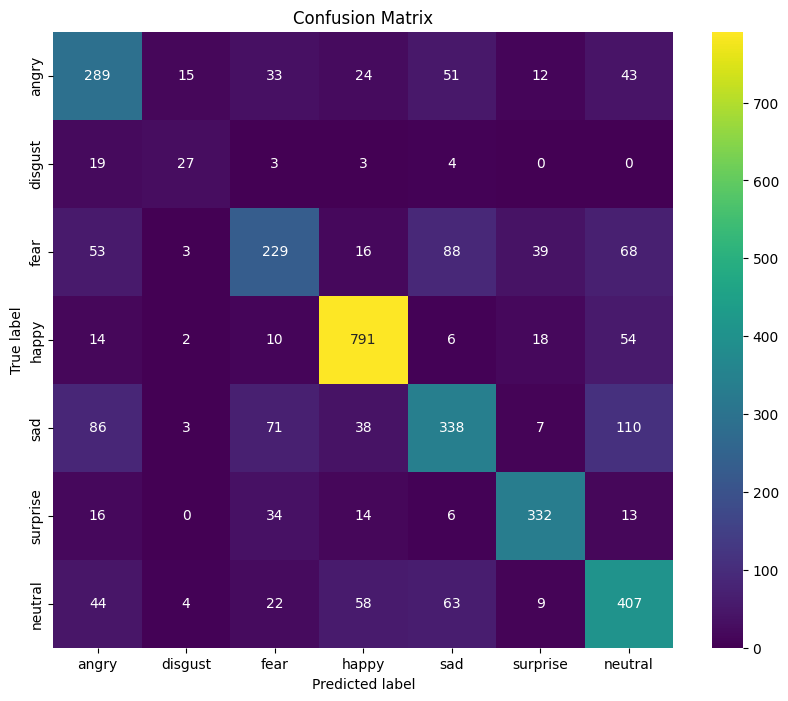

In [14]:
plot.plot_confusion_matrix(results)

In [15]:
plot.display_classification_report(results)

=== Classification Report ===
              precision    recall  f1-score   support

       angry     0.5547    0.6188    0.5850       467
     disgust     0.5000    0.4821    0.4909        56
        fear     0.5697    0.4617    0.5100       496
       happy     0.8379    0.8838    0.8603       895
         sad     0.6079    0.5176    0.5591       653
    surprise     0.7962    0.8000    0.7981       415
     neutral     0.5856    0.6705    0.6252       607

    accuracy                         0.6723      3589
   macro avg     0.6360    0.6335    0.6327      3589
weighted avg     0.6694    0.6723    0.6685      3589



### 6. Model Predictions

In [16]:
# Load model for prediction
MODEL_PATH = './models/outputs/VGGNet_best_valid.pth'
model = vgg.Vgg()
model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

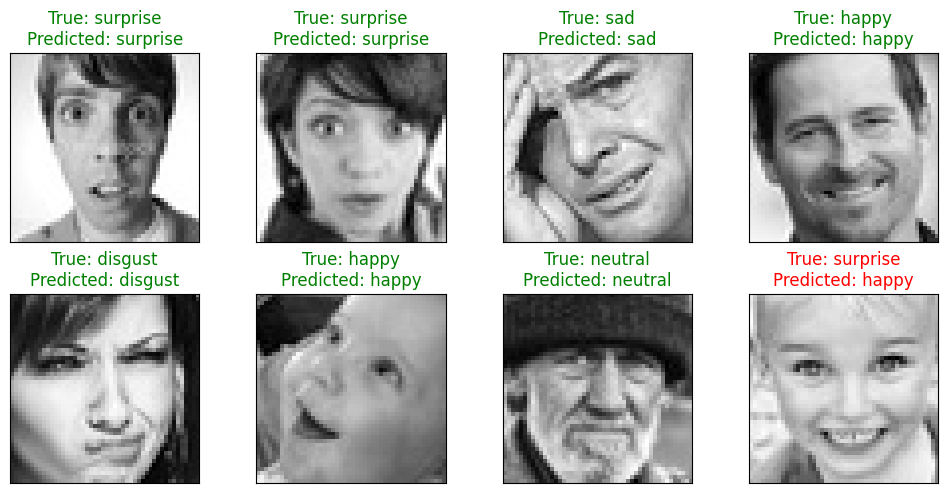

In [17]:
# Plot predictions
plot.plot_predictions(model, test_loader, DEVICE)